# Tutorial: Learning to reconstruct data based on context information

## Contents of Tutorial

This tutorial demonstrates how to use the mmcontext package to construct and train a deep learning network which takes AnnData objects and learns joint representations of context and data information. Here we focus on annotation of data and exploring data through natural language. Therefore a trained model can be provided with a scRNA seq dataset and cell type annotations can be produced. 

We'll walk through the steps of:

**Preprocessing**:
1. Loading the Dataset
2. Generating Embeddings
3. Normalizing Embeddings
4. Aligning Embeddings
5. Constructing the Dataset
6. Creating a Data Loader

**Model fitting**:
1. Initialize the model
2. Configure the loss
3. Train the model

In [100]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from mmcontext.utils import setup_logging

setup_logging()

mmcontext.utils - INFO - mmcontext logging configured using the specified configuration file.


### Preprocessing
#### 1. Loading the Dataset

The input data has to be an {class}`anndata.AnnData` object. First, we'll load the example dataset provided in data/small_cellxgene.h5ad. It is derived from the cellxgene census {cite:p}`czi2023cz` and contains cells of various tissues and celltypes from different studys. It is a custom made dataset that contains data from various tissues originating from different datasets. The scvi embedding included is provided by cellxgene and contains embeddings computed with the scvi variational autoencoder trained on the cellxgene corpus. 

In [3]:
# Import necessary libraries
import anndata
import scanpy as sc

data_path = "../../data/demo/small_cellxgene.h5ad"
# Load the dataset
adata = anndata.read_h5ad(data_path)
# Display basic information about the dataset
print(adata)

AnnData object with n_obs × n_vars = 5600 × 1000
    obs: 'soma_joinid', 'donor_id', 'disease', 'sex', 'dataset_id', 'cell_type', 'assay', 'tissue', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'is_primary_data'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
    obsm: 'metadata_tissue_assay_cell_type', 'scvi'


In [4]:
# Log transformation for reconstruction
sc.pp.log1p(adata)

In [104]:
#!aws s3 cp --no-sign-request --no-progress --only-show-errors s3://cellxgene-contrib-public/models/scvi/2024-02-12/homo_sapiens/model.pt 2024-02-12-scvi-homo-sapiens/scvi.model/


In [5]:
import numpy as np
from pathlib import Path

# subset 20000 cells from the dataset and save both the remaining and the removed cells
n_test = 1000
test_path = "../../data/raw/test/"
train_path = "../../data/raw/train/"
# Create random index for test cells
random_indices = np.random.choice(adata.n_obs, size=n_test, replace=False)

# Create boolean mask and slice the original AnnData
test_mask = np.zeros(adata.n_obs, dtype=bool)
test_mask[random_indices] = True

test_adata = adata[test_mask].copy()
train_adata = adata[~test_mask].copy()
# Ensure output directories exist
Path(test_path).mkdir(parents=True, exist_ok=True)
Path(train_path).mkdir(parents=True, exist_ok=True)

# Write subsets to disk
test_file_path = Path(test_path) / "small_adata_test.h5ad"
train_file_path = Path(train_path) / "small_adata_train.h5ad"

test_adata.write(test_file_path)
train_adata.write(train_file_path)

In [6]:
from mmcontext.pp.utils import remove_entries, consolidate_low_frequency_categories

# split anndata into train and test
# train_adata, test_adata = split_anndata(adata, train_size=0.8)
remove_entries(train_adata)
remove_entries(test_adata)
# remove cells and datasets with less than 5 appearances
train_adata = consolidate_low_frequency_categories(
    train_adata, columns=["cell_type", "dataset_id"], threshold=5, remove=True
)
# remove cells and datasets with less than 5 appearances
test_adata = consolidate_low_frequency_categories(
    test_adata, columns=["cell_type", "dataset_id"], threshold=5, remove=True
)

mmcontext.pp.utils - INFO - No cells with zero variance found.
mmcontext.pp.utils - INFO - No cells with zero variance found.


#### 2. Generate Embeddings

We will generate context embeddings based on the categorical metadata fields cell_type and tissue using the {class}`mmcontext.pp.CategoryEmbedder` class.
The method is based on creating an embedding of the individual categories of a cell with a text model. The `embeddings_file_path` points to a dictionary that contains embeddings for a range of cell types and tissues from the cellxgene corpus, thereby allowing the method to work without needing an API call. Only if some categories are not found in the dictionary the api will be used. If only a few are unknown, these will just be filled with a zero embedding. The `unkown_threshold` parameter controls how many new categories are needed to use the API. For that of course an API Key will be needed, which has to be set as an environmental variable "OPENAI_API_KEY". 

We will use the precomputed data embeddings stored in `adata.obsm['scvi']` as our data embeddings

In [7]:
# Import the CategoryEmbedder class
from mmcontext.pp import CategoryEmbedder, Embedder, AnnDataStoredEmbedder

# Specify the categories to embed
categories = ["cell_type"]
one_hot = False
# Initialize the CategoryEmbedder
category_embedder = CategoryEmbedder(
    metadata_categories=categories,
    model="text-embedding-3-small",
    combination_method="concatenate",
    embeddings_file_path="../../data/emb_dicts/category_embeddings_text-embedding-3-small_metadata_embeddings.pkl.gz",
    one_hot=one_hot,
)
data_embedder = AnnDataStoredEmbedder(obsm_key="scvi")
# Initialize the Embedder without embedders
embedder = Embedder(context_embedder=category_embedder, data_embedder=data_embedder)

# Create embeddings using external embeddings
for adata in [train_adata, test_adata]:
    embedder.create_embeddings(adata)
    # Confirm the shape of the context embeddings
    print("Context Embeddings Shape:", adata.obsm["c_emb"].shape)
    print("Data Embeddings Shape:", adata.obsm["d_emb"].shape)

mmcontext.pp.context_embedder - INFO - Loaded embeddings from file.
mmcontext.pp.context_embedder - INFO - Embeddings dictionary contains the following categories: dict_keys(['cell_type', 'tissue', 'assay']) with a total of 947 elements.
mmcontext.pp.embedder - INFO - Creating data embeddings...
mmcontext.pp.data_embedder - INFO - Fetched existing embeddings from adata.obsm['scvi'] of shape (4408, 50).
mmcontext.pp.embedder - INFO - Creating context embeddings...
mmcontext.pp.context_embedder - INFO - Embeddings for 'cell_type' stored in adata.obsm['cell_type_emb']
mmcontext.pp.context_embedder - INFO - Combined context embeddings stored in adata.obsm['c_emb']
Context Embeddings Shape: (4408, 1536)
Data Embeddings Shape: (4408, 50)
mmcontext.pp.embedder - INFO - Creating data embeddings...
mmcontext.pp.data_embedder - INFO - Fetched existing embeddings from adata.obsm['scvi'] of shape (823, 50).
mmcontext.pp.embedder - INFO - Creating context embeddings...
mmcontext.pp.context_embedder

#### 3. Normalize Embeddings 

Now that the embeddings are created and stored in the adata object we can apply normalization. We will use the {class}`mmcontext.pp.MinMaxNormalizer` here. 

In [8]:
# Import the MinMaxNormalizer class
from mmcontext.pp import MinMaxNormalizer

# Initialize the MinMaxNormalizer
normalizer = MinMaxNormalizer()
# Normalize the embeddings
for adata in [train_adata, test_adata]:
    normalizer.normalize(adata)

    # Confirm that normalized embeddings are stored
    print("Normalized Data Embeddings Shape:", adata.obsm["d_emb_norm"].shape)
    print("Normalized Context Embeddings Shape:", adata.obsm["c_emb_norm"].shape)

mmcontext.pp.embedding_normalizer - INFO - Normalizing embeddings using min-max normalization...
Normalized Data Embeddings Shape: (4408, 50)
Normalized Context Embeddings Shape: (4408, 1536)
mmcontext.pp.embedding_normalizer - INFO - Normalizing embeddings using min-max normalization...
Normalized Data Embeddings Shape: (823, 50)
Normalized Context Embeddings Shape: (823, 1536)


#### 4. Aligning Embeddings

After normalization we will now use a {class}`mmcontext.pp.DimAligner` to make sure the dimensions of both data and context embeddings are equal, as this will be nescessary for the model. We will use the {class}`mmcontext.pp.PCAReducer` for this. If embeddings are larger than target latent dimension, they will be reduced via PCA. If there are smaller, padding with zeros will be applied. If using the {class}`mmcontext.pp.PCAReducer`, you can evaluate the principal components with some plots and metrics.

In [9]:
from omegaconf import DictConfig

# Create a DictConfig object for the configuration
config = DictConfig(
    {
        "evaluate_pca": True,
        "save_path": "pca_eval_oh",
        "scree_plot": True,
        "cumulative_variance_plot": True,
        "loadings_heatmap": True,
        "loadings_heatmap_options": {
            "threshold": 0,  # Only include loadings above this threshold
            "top_n_components": 64,  # Number of principal components to include in the heatmap
            "top_n_variables": 1000,  # Number of variables to display in the heatmap
        },
    }
)
# Configuration dictionary for PCA evaluation

if config.evaluate_pca and one_hot:
    config.one_hot_order = adata.uns["one_hot_order"]

In [10]:
# Import the PCAReducer class
from mmcontext.pp import PCAReducer

# Initialize the PCAReducer with the desired latent dimension
latent_dim = 64
aligner = PCAReducer(latent_dim=latent_dim, config=config)

# Align the embeddings
for adata in [train_adata, test_adata]:
    aligner.align(adata)

    # Confirm that aligned embeddings are stored
    print("Aligned Data Embeddings Shape:", adata.obsm["d_emb_aligned"].shape)
    print("Aligned Context Embeddings Shape:", adata.obsm["c_emb_aligned"].shape)

mmcontext.pp.dim_aligner - INFO - one_hot_order not provided. Using default feature indices.
mmcontext.pp.dim_aligner - INFO - Applied threshold: 0
mmcontext.pp.dim_aligner - INFO - Selected top 1000 variables based on importance.
mmcontext.pp.dim_aligner - INFO - Loadings heatmap saved to pca_eval_oh/loadings_heatmap.png
mmcontext.pp.dim_aligner - INFO - Loadings heatmap generation complete.
Aligned Data Embeddings Shape: (4408, 64)
Aligned Context Embeddings Shape: (4408, 64)
mmcontext.pp.dim_aligner - INFO - one_hot_order not provided. Using default feature indices.
mmcontext.pp.dim_aligner - INFO - Applied threshold: 0
mmcontext.pp.dim_aligner - INFO - Selected top 1000 variables based on importance.
mmcontext.pp.dim_aligner - INFO - Loadings heatmap saved to pca_eval_oh/loadings_heatmap.png
mmcontext.pp.dim_aligner - INFO - Loadings heatmap generation complete.
Aligned Data Embeddings Shape: (823, 64)
Aligned Context Embeddings Shape: (823, 64)


#### 5. Constructing the Dataset

Finally, we will construct a dataset using the aligned embeddings, suitable for training models with PyTorch.

In [11]:
# Import the DataSetConstructor class
from mmcontext.pp import DataSetConstructor

# The sequence length for the dataset. Since attention mechanisms will be used, samples can be grouped into sequences to perform attention within the sequence.
seq_length = 32
batch_size = 16
# Initialize the DataSetConstructor
train_dataset_constructor = DataSetConstructor(
    out_emb_keys={"data_embedding": "d_emb", "context_embedding": "c_emb"},
    use_raw=True,
    chunk_size=seq_length * batch_size,
    batch_size=batch_size,
    use_dask=True,
)
test_dataset_constructor = DataSetConstructor(
    out_emb_keys={"data_embedding": "d_emb", "context_embedding": "c_emb"},
    use_raw=True,
    chunk_size=seq_length * batch_size,
    batch_size=batch_size,
    use_dask=True,
)

# Add the AnnData object to the dataset
train_dataset_constructor.add_anndata(
    train_adata,
    emb_keys={"data_embedding": "d_emb_aligned", "context_embedding": "c_emb_aligned"},
    sample_id_key="soma_joinid",
)
test_dataset_constructor.add_anndata(
    test_adata,
    emb_keys={"data_embedding": "d_emb_aligned", "context_embedding": "c_emb_aligned"},
    sample_id_key="soma_joinid",
)


# Construct the dataset
train_dataset = train_dataset_constructor.construct_dataset(seq_length=seq_length)
test_dataset = test_dataset_constructor.construct_dataset(seq_length=seq_length)

#### 6. Create a Dataloader
Create a pyTorch Dataloader which can be iterated over

In [15]:
from torch.utils.data import DataLoader

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
# For now use the test data as validation data
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Iterate over DataLoader and verify batch shapes
for batch in train_loader:
    data_embeddings = batch["d_emb"]  # Shape: (batch_size, seq_length, embedding_dim)
    context_embeddings = batch["c_emb"]  # Shape: (batch_size, seq_length, embedding_dim)
    sample_ids = batch["sample_id"]  # Shape: (batch_size, seq_length)
    raw_data = batch["raw_data"]  # Shape: (batch_size, seq_length, num_features)

    print(data_embeddings.shape)
    print(context_embeddings.shape)
    print(sample_ids.shape)
    print(raw_data.shape)
    break  # Only need to check the first batch

torch.Size([16, 32, 64])
torch.Size([16, 32, 64])
torch.Size([16, 32])
torch.Size([16, 32, 1000])


### Model fitting
#### 1. Initializing the Model
The {class}`mmcontext.engine.MMContextEncoder` is the main encoder which will be used to create embeddings based on the available data and context embeddings. It's structure is flexible and is build upon torchs {class}`torch.nn.TransformerEncoder` which creates stacks of the {class}`mmcontext.engine.CustomTransformerEncoderLayer` which can be configured to be 

1. To apply self attention (use_self_attention = True)
2. To apply cross attention (use_cross_attention = True)
3. To use both self and cross attention (both True)
4. An MLP only model (both False)

The model takes two matrix inputs, `in_main` and `in_cross`. in_main will be passed through the MLP and optionally the self-attention layers, while in_cross is only used if cross-attention is used. In the end the model outputs embeddings of the same shape as in_main, updated based on the learning objective. The inputs are handled in the {class}`mmcontext.engine.Trainer` in dependancy with the settings used for the loss. 

In [16]:
from mmcontext.engine import MMContextEncoder

hidden_dim = 64
num_layers = 1
num_heads = 1
encoders = {}
encoders["data_encoder"] = MMContextEncoder(
    embedding_dim=latent_dim,  # this has to be the same dimension as the latent dimension of the aligner
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    num_heads=num_heads,
    use_self_attention=False,
    use_cross_attention=False,
    activation="relu",
    dropout=0.1,
)
encoders["context_encoder"] = MMContextEncoder(
    embedding_dim=latent_dim,  # this has to be the same dimension as the latent dimension of the aligner
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    num_heads=num_heads,
    use_self_attention=False,
    use_cross_attention=False,
    activation="relu",
    dropout=0.1,
)
# decoder = ZINBDecoder(
#    input_dim=latent_dim,
#    hidden_dims=[64, 128],
#    output_dim=train_adata.shape[1],  # number of genes
# )

mmcontext.engine.models - INFO - MMContextEncoder initialized with embedding_dim = 64, num_layers = 1, use_self_attention = False, use_cross_attention = False.
mmcontext.engine.models - INFO - MMContextEncoder initialized with embedding_dim = 64, num_layers = 1, use_self_attention = False, use_cross_attention = False.


#### 2. Configure the loss
The loss function is a central part of this project. The loss is implemented to be extendable and customizable by having a {class}`mmcontext.engine.LossManager` which you can use to add different losses to and which will be passed to the {class}`mmcontext.engine.Trainer` to compute the total loss (as a weighted average of the components) during Training. The current main implementation of a {class}`mmcontext.engine.LossFunction` is the {class}`mmcontext.engine.ContrastiveLoss`, which is a custom approach to contrastive learning. It's main configuration parameters are `target_mode` and `current_mode` which refer to the way in which the target similarity matrix and the current (during model training) similarity matrix are constructed. For example if `target_mode = 'context_context'`, the original context embeddings are used to create the target similarity matrix. Therefore during training, the loss is calcualted as the mean squared error between the current similarity matrix and the one based on the context. If `current_mode = 'data_data'`, the model would learn to find representations of the data that represent similarity found in the respective context.  

In [17]:
from mmcontext.engine import LossManager, ContrastiveLoss

loss_manager = LossManager()
loss_manager.add_loss(ContrastiveLoss(target_mode="infoNCE", current_mode="data_context", similarity_metric="cosine"))
# loss_manager.add_loss(ZINBLoss(), weight=0.01)

mmcontext.engine.losses - INFO - Adding loss function: ContrastiveLoss(target_mode=infoNCE, current_mode=data_context, similarity_metric=cosine) with weight 1.00


#### 3. Train the Model
The Trainer uses the defined model and loss the conduct training, aiming to iterativly minimize the loss. The {func}`mmcontext.engine.Trainer.fit` method can take a training and a validation dataloader as input. If a validation loader is given and a save_path is used, the weights of the best performing model can be saved to file. The {class}`mmcontext.engine.MMContextEncoder` has a method `load` to load weights from file.
Per default data embeddings are used for in_main while context embeddings are used as in_cross.

In [25]:
from mmcontext.engine import Trainer
import torch

model_parameters = []
for encoder_key in encoders.keys():
    model_parameters += list(encoders[encoder_key].parameters())
trainer = Trainer(
    encoders=encoders,
    decoder=None,
    loss_manager=loss_manager,
    optimizer=torch.optim.Adam(model_parameters),
    encoder_inputs={
        "data_encoder": {"in_main": "d_emb", "in_cross": "c_emb"},
        "context_encoder": {"in_main": "c_emb", "in_cross": "d_emb"},
    },
    temperature=0.07,
    device=torch.device("cpu"),
)

mmcontext.engine.trainer - INFO - Running on device: cpu
mmcontext.engine.models - INFO - Placeholder model initialized.


The {class}`mmcontext.eval.SystemMonitor` is used to track CPU and GPU usage as well as file reading/writing speed.

In [26]:
from mmcontext.eval.system_usage import SystemMonitor

monitor = SystemMonitor(interval=0.1)
monitor.start()

res = trainer.fit(train_loader, val_loader, epochs=5, save=True)

monitor.stop()

mmcontext.eval.system_usage - INFO - No NVIDIA GPU detected or pynvml not installed.
mmcontext.eval.system_usage - INFO - No supported GPU detected.
mmcontext.engine.trainer - INFO - Starting Epoch 1/5
mmcontext.engine.trainer - INFO - Batch 9/9, Loss: 5.3367, Time per sample: 5.93µs
mmcontext.engine.trainer - INFO - Training Epoch Complete. Average Loss: 5.8587
mmcontext.engine.trainer - INFO - Validation Complete. Average Loss: 6.5429
mmcontext.engine.trainer - INFO - Epoch 1/5 - Train Loss: 5.8587, Val Loss: 6.5429
mmcontext.engine.models - INFO - Saving model state dictionary to best_encoder_weights/best_data_encoder_weights.pth
mmcontext.engine.trainer - INFO - Validation loss improved. Encoder 'data_encoder' weights saved.
mmcontext.engine.models - INFO - Saving model state dictionary to best_encoder_weights/best_context_encoder_weights.pth
mmcontext.engine.trainer - INFO - Validation loss improved. Encoder 'context_encoder' weights saved.
mmcontext.engine.models - INFO - Placeho

In [23]:
monitor.print_summary()


System Resource Usage Summary:
Core Utilization (mean/max % per core): 14.26/18.02% on 16 cores
Memory Usage (mean/max GB): 1.02/1.04 GB
Total System Memory: 128.00 GB
Baseline Memory Usage: 24.54 GB
Disk Read Rate (mean/max MB/s): 0.80/5.49 MB/s
Disk Write Rate (mean/max MB/s): 0.61/3.92 MB/s
No supported GPU detected.
Number of Threads (mean/max): 43.00/43


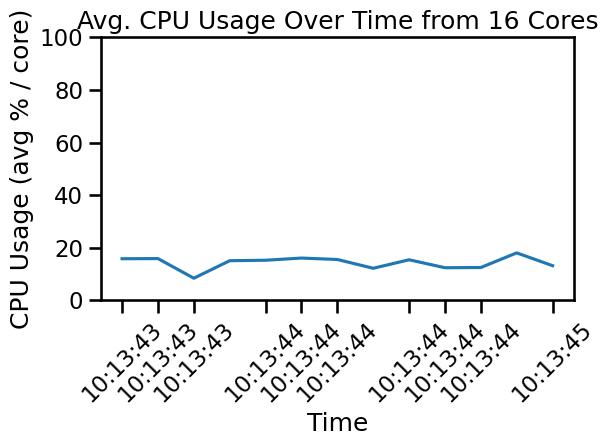

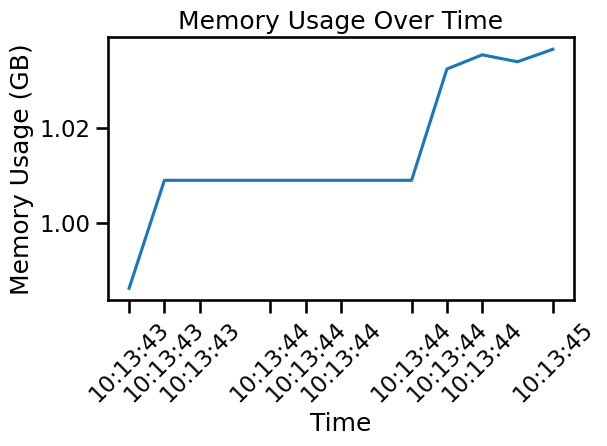

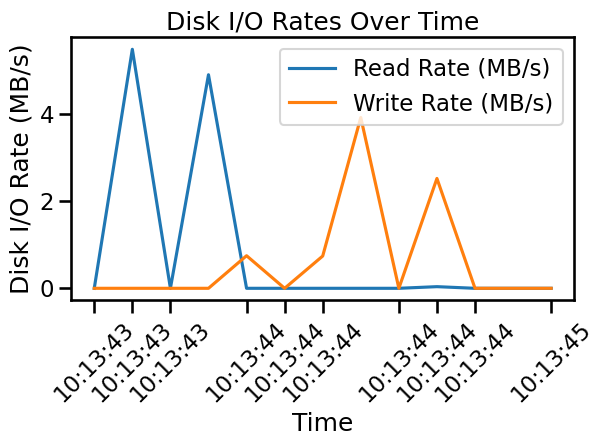

In [24]:
monitor.plot_metrics()

In [42]:
# The fitted model can be used to create universial embeddings
for encoder_key in encoders.keys():
    encoders[encoder_key].load(file_path=f"best_encoder_weights/best_{encoder_key}_weights.pth")
trainer = Trainer(
    encoders=encoders,
    encoder_inputs={
        "data_encoder": {"in_main": "d_emb", "in_cross": "c_emb"},
        "context_encoder": {"in_main": "c_emb", "in_cross": "d_emb"},
    },
    device=torch.device("cpu"),
)
trainer.infer_adata(
    test_adata,
    sample_id_key="soma_joinid",
    seq_length=seq_length,
    batch_size=batch_size,
    chunk_size=seq_length * batch_size,
    output_zarr_path="inferred_adata.zarr",
    n_recon=2,
)

mmcontext.engine.models - INFO - Loading model state dictionary from best_encoder_weights/best_data_encoder_weights.pth
mmcontext.engine.models - INFO - Loading model state dictionary from best_encoder_weights/best_context_encoder_weights.pth
mmcontext.engine.trainer - INFO - Running on device: cpu
mmcontext.engine.models - INFO - Placeholder model initialized.


In [43]:
inferred_adata = anndata.read_zarr("inferred_adata.zarr")

In [45]:
inferred_adata.X.toarray()

array([[0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 3.295837, ..., 0.      , 0.      , 0.      ],
       ...,
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ]],
      dtype=float32)

#### 4. Evaluate the embeddings
In order to assess the quality of the embeddings, the {class}`mmcontext.eval.scibEvaluator` can be used. It computes metrics from the scib package {cite:p}`luecken2022benchmarking` in order to asess bioconservation and batch integration. This can also be judged visualy with a umap.

In [23]:
from mmcontext.eval.clustering import (
    combine_original_and_reconstructions,
    cluster_combined_adata,
)

# Suppose `inferred_adata` has .X for the original data and multiple .layers for reconstructed data
combined_adata = combine_original_and_reconstructions(inferred_adata, max_reconstructions=3)
# Make sure we have unique IDs
combined_adata.obs_names_make_unique()
combined_adata.var_names_make_unique()

combined_adata = cluster_combined_adata(combined_adata, clustering_method="leiden", resolution=1.0)

mmcontext.eval.clustering - INFO - Combining original data with up to 3 reconstruction layers.
mmcontext.eval.clustering - INFO - Processing reconstruction layer: reconstructed1
mmcontext.eval.clustering - INFO - Processing reconstruction layer: reconstructed2
mmcontext.eval.clustering - INFO - Concatenating 3 AnnData objects.
mmcontext.eval.clustering - INFO - Combination complete. Returning combined AnnData with shape (59520, 5000).
mmcontext.eval.clustering - INFO - Clustering combined AnnData with 59520 cells.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/mengerj/repos/mmcontext/src/mmcontext/eval/clustering.py:153: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with ig

mmcontext.eval.clustering - INFO - Clustering complete. Found 39 clusters.


mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
mmcontext.pl.plotting - INFO - Embedding key is None; using default neighbors.


<Figure size 800x800 with 0 Axes>

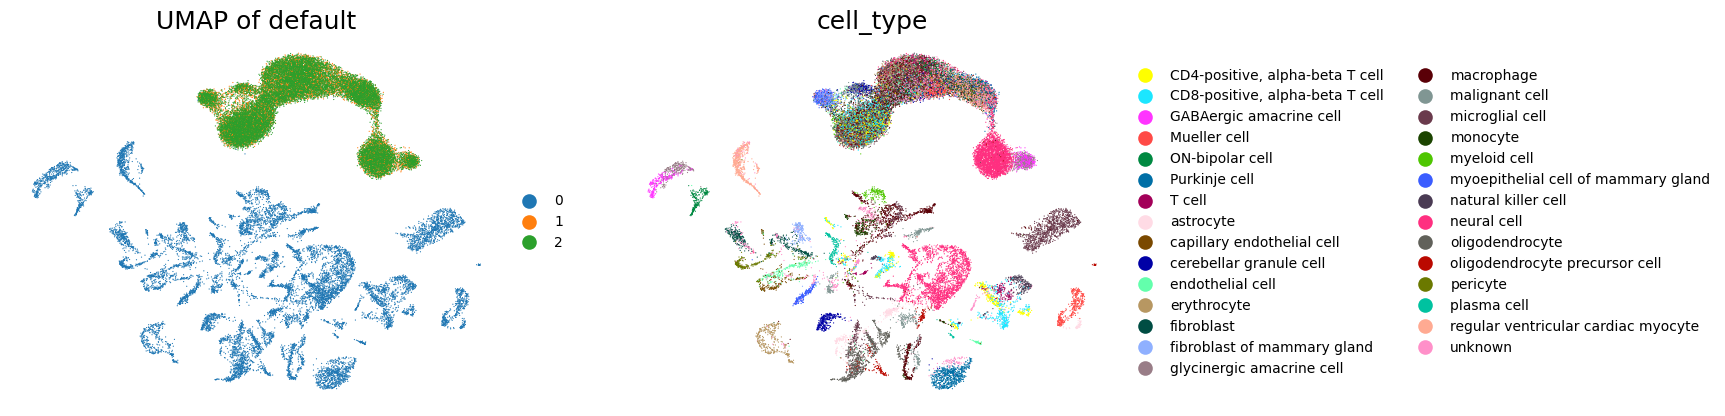

mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.


In [24]:
from mmcontext.pl.plotting import plot_umap

combined_adata_red = consolidate_low_frequency_categories(
    combined_adata, columns=["cell_type"], threshold=500, remove=True
)
plot_umap(combined_adata_red, color_key=["origin", "cell_type"])

mmcontext.pl.plotting - INFO - Starting plot_cells_by_genes_heatmap.
mmcontext.pl.plotting - INFO - Selected 30 HVGs based on cells with origin == '0'.


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:305: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


mmcontext.pl.plotting - INFO - Heatmap saved at clustered_heatmap.png


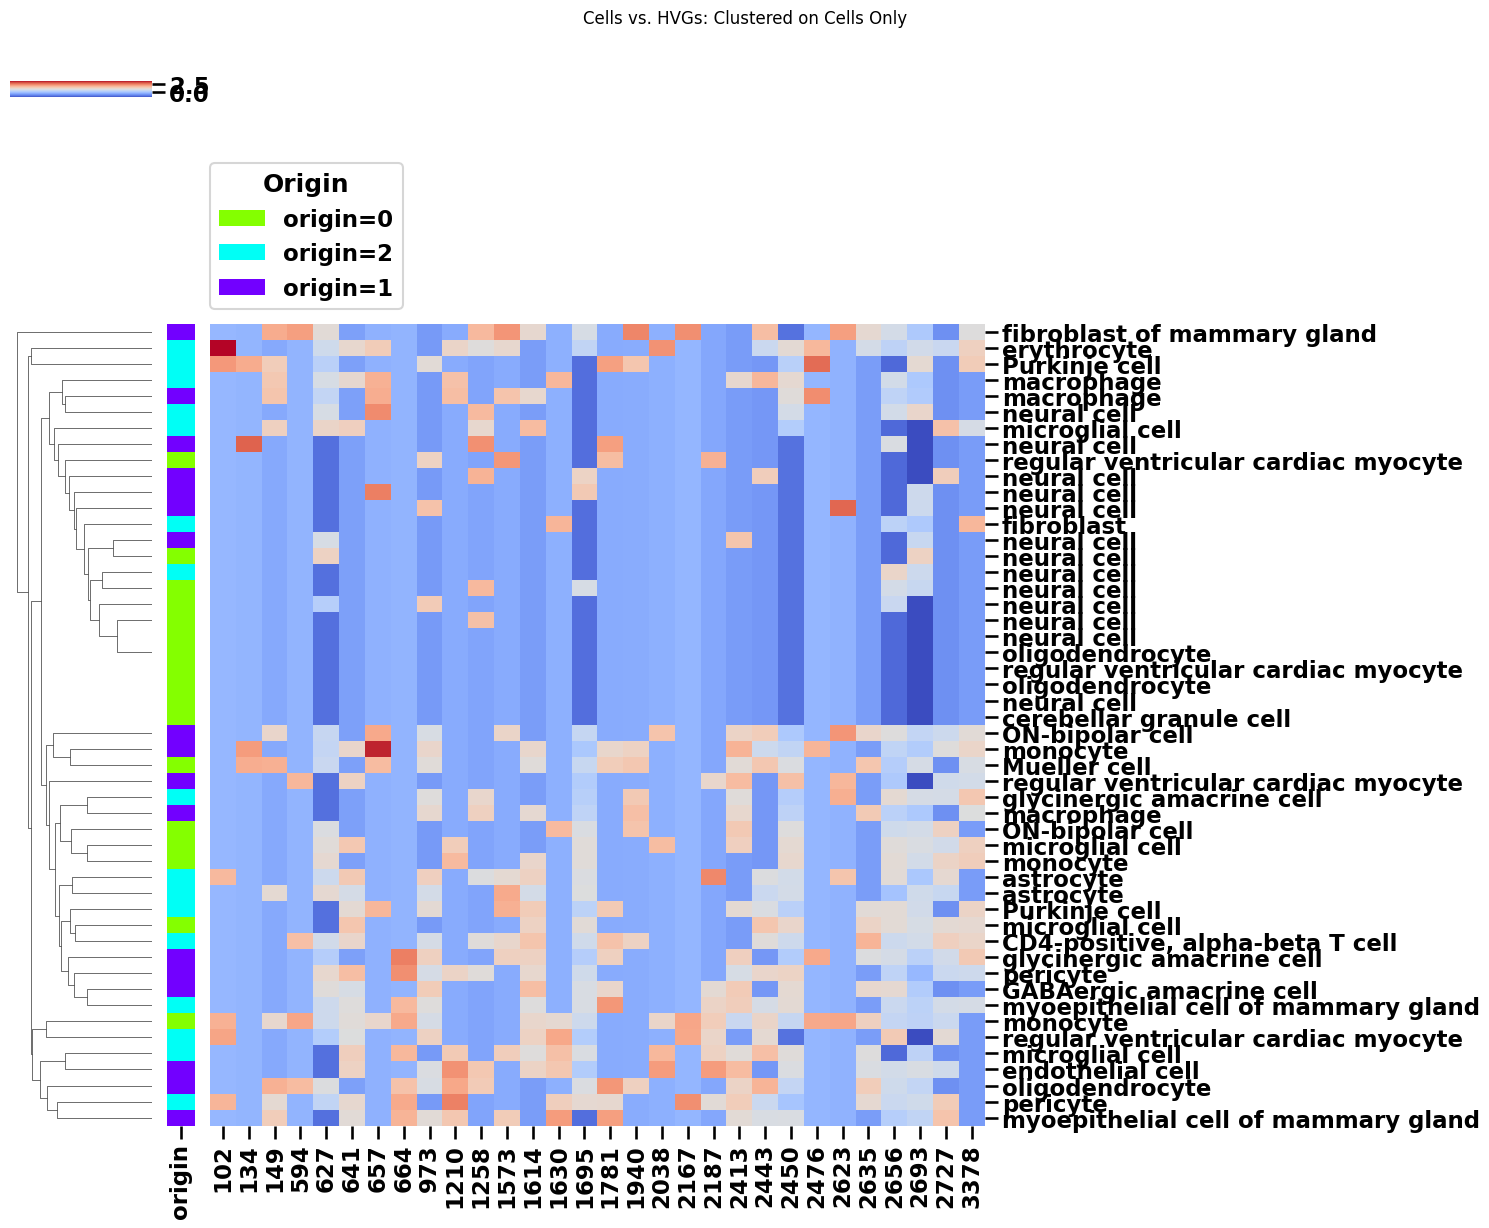

In [212]:
from mmcontext.pl.plotting import plot_clustered_heatmap

# Optionally subsample for heatmap clarity
from mmcontext.eval.clustering import subsample_adata

subsampled_adata = subsample_adata(combined_adata, subsample_size=50)
# Assuming `combined_adata_red` is your AnnData object after preprocessing
plot_clustered_heatmap(
    adata=subsampled_adata,
    num_hvgs=30,  # Select top 30 highly variable genes from original data
    clustering_method="leiden",
    resolution=1.0,
    figsize=(15, 12),
    cmap="coolwarm",
    show=True,
    save_path="clustered_heatmap.png",
)

mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
mmcontext.pl.plotting - INFO - Computing neighbors with use_rep='data_encoder_mod_emb'.


<Figure size 800x800 with 0 Axes>

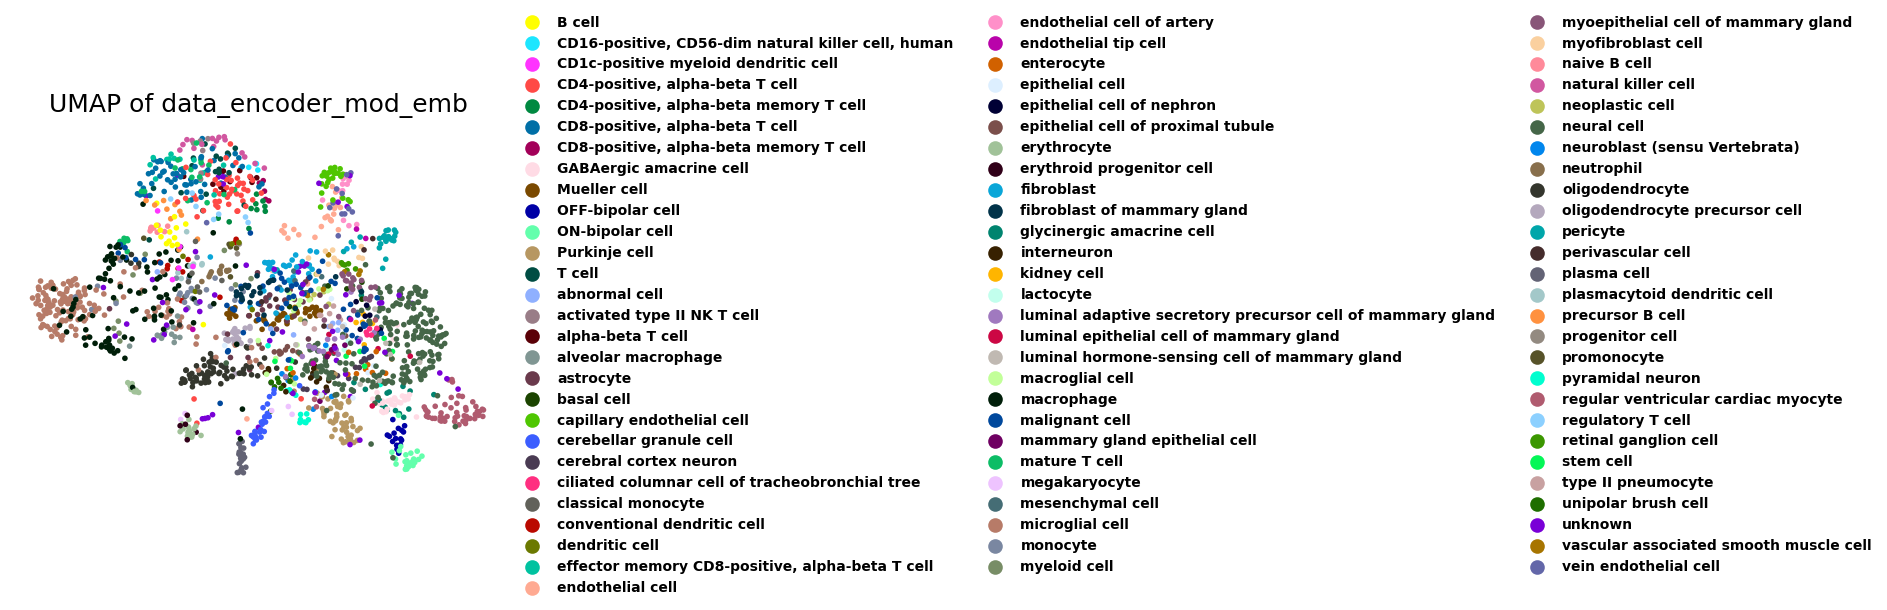

mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.


In [49]:
from mmcontext.pl import plot_umap

inferred_adata_red = consolidate_low_frequency_categories(
    inferred_adata, columns=["cell_type"], threshold=1, remove=True
)
# inferred_adata_red.obsm["recon"] = inferred_adata_red.layers["reconstructed1"]
plot_umap(inferred_adata_red, color_key="cell_type", embedding_key="data_encoder_mod_emb", save_plot=False)

mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
mmcontext.pl.plotting - INFO - Computing neighbors with use_rep='reconstructed'.


<Figure size 800x800 with 0 Axes>

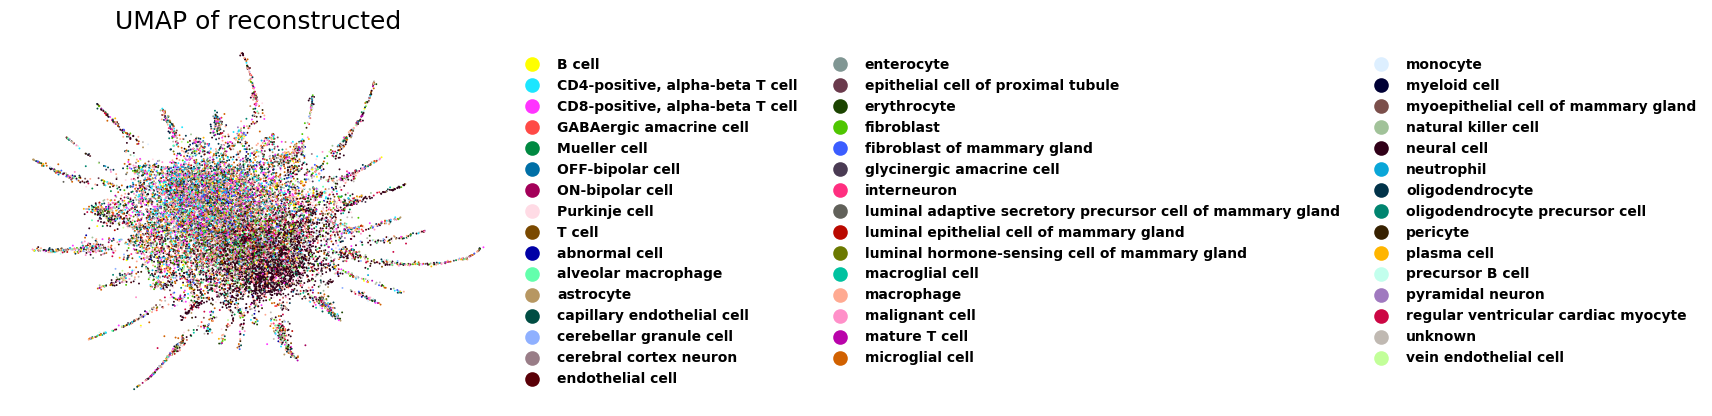

mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.


In [26]:
inferred_adata.obsm["reconstructed"] = inferred_adata.layers["reconstructed1"]
plot_umap(inferred_adata, color_key="cell_type", embedding_key="reconstructed", save_plot=False)

In [62]:
# Different random realizations of the reconstructed data are stored in the layers of the inferred_adata object
inferred_adata.layers

Layers with keys: reconstructed1, reconstructed2

In [50]:
from mmcontext.pl.plotting import plot_umap
from mmcontext.eval import scibEvaluator

# Initialize scibEvaluator
evaluator = scibEvaluator(
    adata=inferred_adata,
    batch_key="dataset_id",
    label_key="cell_type",
    embedding_key=["scvi", "context_encoder_mod_emb"],
    reconstructed_keys=list(inferred_adata.layers),
    max_cells=2000,  # subsample cells for faster computation
)

In [51]:
from mmcontext.eval.system_usage import SystemMonitor

res = evaluator.evaluate()

mmcontext.eval.evaluate_scib - INFO - Computing metrics on raw data...
mmcontext.eval.evaluate_scib - INFO - Computing PCA on all genes...
Cluster for cluster_0.2 with leiden
resolution: 0.2, nmi: 0.5473479081292905
Cluster for cluster_0.4 with leiden
resolution: 0.4, nmi: 0.5789807829491751
Cluster for cluster_0.6 with leiden
resolution: 0.6, nmi: 0.5896635975381113
Cluster for cluster_0.8 with leiden
resolution: 0.8, nmi: 0.5900193758435798
Cluster for cluster_1.0 with leiden
resolution: 1.0, nmi: 0.6162141595834755
Cluster for cluster_1.2 with leiden
resolution: 1.2, nmi: 0.6160555150144097
Cluster for cluster_1.4 with leiden
resolution: 1.4, nmi: 0.6129875944087544
Cluster for cluster_1.6 with leiden
resolution: 1.6, nmi: 0.6262651739729022
Cluster for cluster_1.8 with leiden
resolution: 1.8, nmi: 0.6250851489688516
Cluster for cluster_2.0 with leiden
resolution: 2.0, nmi: 0.6307623876493003
optimised clustering against cell_type
optimal cluster resolution: 2.0
optimal score: 0.630

/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


resolution: 0.6, nmi: 0.9764229030119481
Cluster for cluster_0.8 with leiden
resolution: 0.8, nmi: 0.9764229030119481
Cluster for cluster_1.0 with leiden
resolution: 1.0, nmi: 0.9764229030119481
Cluster for cluster_1.2 with leiden
resolution: 1.2, nmi: 0.9764229030119481
Cluster for cluster_1.4 with leiden
resolution: 1.4, nmi: 0.9764229030119481
Cluster for cluster_1.6 with leiden
resolution: 1.6, nmi: 0.9764229030119481
Cluster for cluster_1.8 with leiden
resolution: 1.8, nmi: 0.9764229030119481
Cluster for cluster_2.0 with leiden
resolution: 2.0, nmi: 0.9787844228183953
optimised clustering against cell_type
optimal cluster resolution: 2.0
optimal score: 0.9787844228183953
isolated labels: no more than 1 batches per label
isolated labels: ['CD16-positive, CD56-dim natural killer cell, human', 'CD4-positive, alpha-beta memory T cell', 'CD8-positive, alpha-beta memory T cell', 'GABAergic amacrine cell', 'Mueller cell', 'OFF-bipolar cell', 'ON-bipolar cell', 'Purkinje cell', 'abnormal 

/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Cluster for iso_label_0.4 with leiden
CD16-positive, CD56-dim natural killer cell, human: 1.0
CD4-positive, alpha-beta memory T cell: 1.0
CD8-positive, alpha-beta memory T cell: 0.9999999403953552
GABAergic amacrine cell: 1.0
Mueller cell: 1.0
OFF-bipolar cell: 0.9999999403953552
ON-bipolar cell: 0.9999998807907104
Purkinje cell: 1.0
abnormal cell: 1.0
activated type II NK T cell: 1.0
alpha-beta T cell: 1.0
basal cell: 1.0
resolution: 0.4, max_f1: 0.38461538461538464
Cluster for iso_label_0.6 with leiden
cerebellar granule cell: 1.0
cerebral cortex neuron: 1.0
ciliated columnar cell of tracheobronchial tree: 0.9999999403953552
effector memory CD8-positive, alpha-beta T cell: 1.0
endothelial tip cell: 0.9999999403953552
epithelial cell of nephron: 1.0
fibroblast of mammary gland: 1.0
glycinergic amacrine cell: 1.0
kidney cell: 1.0
lactocyte: 1.0
luminal adaptive secretory precursor cell of mammary gland: 1.0
luminal hormone-sensing cell of mammary gland: 1.0
macroglial cell: 1.0
mature 

/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


mean silhouette per group:                                           silhouette_score
group                                                     
B cell                                            1.000000
CD1c-positive myeloid dendritic cell              1.000000
CD4-positive, alpha-beta T cell                   1.000000
CD8-positive, alpha-beta T cell                   1.000000
T cell                                            1.000000
alveolar macrophage                               1.000000
astrocyte                                         1.000000
capillary endothelial cell                        1.000000
classical monocyte                                1.000000
conventional dendritic cell                       1.000000
endothelial cell                                  1.000000
endothelial cell of artery                        1.000000
enterocyte                                        1.000000
epithelial cell                                   0.794750
epithelial cell of proximal t

In [125]:
res

,data_id,hvg,type,ARI,NMI,ASW,Isolated_Labels_ASW,Isolated_Labels_F1,Bio_Conservation_Score,Graph_Connectivity,Silhouette_Batch,Batch_Integration_Score,Overall_Score
0,,None,raw,0.354418,0.637570,0.410125,0.538921,0.422006,0.472608,0.828548,0.702436,0.765492,0.589762
1,,None,reconstructed1,0.442281,0.535276,0.503565,0.486934,0.304795,0.454570,0.657011,0.927124,0.792067,0.589569
2,,None,reconstructed2,0.444866,0.547602,0.507403,0.474455,0.224448,0.439755,0.655616,0.916437,0.786026,0.578263
3,,None,embedding_scvi,0.397875,0.705263,0.517042,0.559868,0.550763,0.546162,0.917241,0.789632,0.853436,0.669072
4,,None,embedding_context_encoder_mod_emb,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We can also compare the reconstructed matrix and the original matrix. We do this by computing a variety of data properties and comparing them between orignal and reconstructed data

mmcontext.pl.plotting - INFO - Generating grouped bar chart with metrics on x-axis and type categories as color groups.


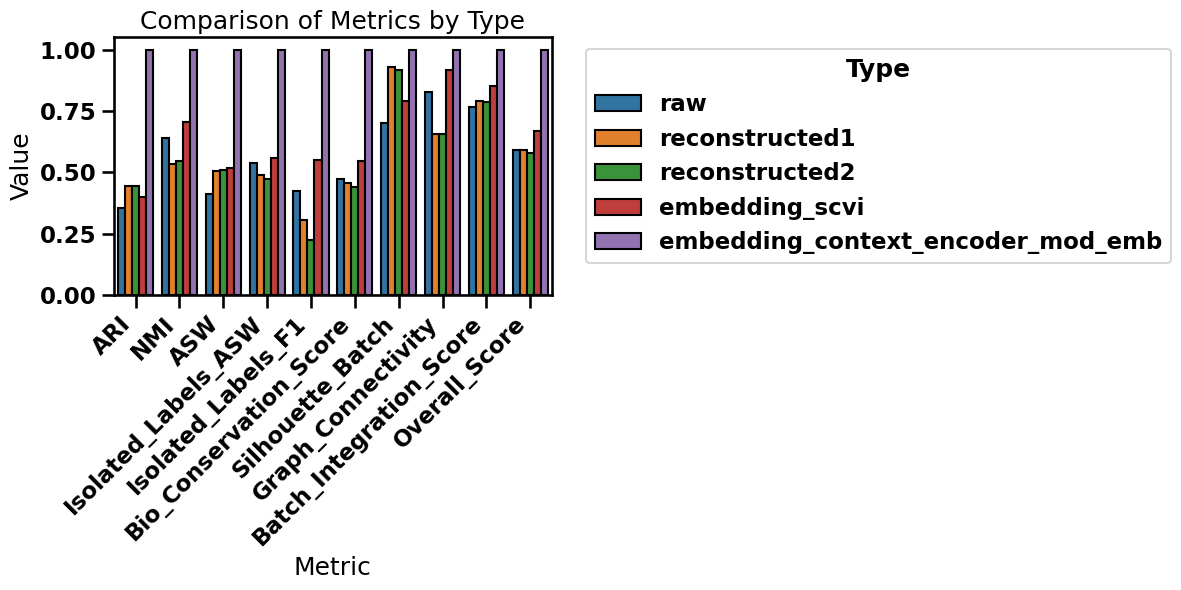

mmcontext.pl.plotting - INFO - Displayed grouped bar chart interactively.


In [126]:
from mmcontext.pl.plotting import plot_grouped_bar_chart

plot_grouped_bar_chart(res, save_plot=False)

In [90]:
# Initialize the DataProperties object
from mmcontext.eval import DataProperties

dp = DataProperties(predefined_subset="microbiome")

In [91]:
dp.add_original_data(test_adata.X.toarray())

mmcontext.eval.data_properties - INFO - Using predefined microbiome subset.
mmcontext.eval.data_properties - WARNING - Warning computing bimodalityColCorr: An input array is constant; the correlation coefficient is not defined.
mmcontext.eval.data_properties - WARNING - Warning computing meanColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - WARNING - Warning computing meanColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - WARNING - Warning computing sdColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - WARNING - Warning computing sdColCorr: invalid value encountered in divide


In [92]:
# Add reconstructed data to DataProperties object
for reconstructed_data in inferred_adata.layers:
    dp.add_reconstructed_data(inferred_adata.layers[reconstructed_data])

mmcontext.eval.data_properties - INFO - Using predefined microbiome subset.
mmcontext.eval.data_properties - WARNING - Warning computing meanColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - WARNING - Warning computing meanColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - WARNING - Warning computing LinCoefPoly2: Polyfit may be poorly conditioned
mmcontext.eval.data_properties - WARNING - Warning computing QuadCoefPoly2: Polyfit may be poorly conditioned
mmcontext.eval.data_properties - INFO - Using predefined microbiome subset.
mmcontext.eval.data_properties - WARNING - Warning computing LinCoefPoly2: Polyfit may be poorly conditioned
mmcontext.eval.data_properties - WARNING - Warning computing QuadCoefPoly2: Polyfit may be poorly conditioned


In [85]:
# simulate new data and perform the same procedure
# This could be a different test dataset
test_adata2 = test_adata.copy()
test_adata2.X += np.random.normal(0, 1e-6, size=test_adata2.X.shape)
dp.add_original_data(test_adata.X.toarray())

mmcontext.eval.data_properties - INFO - Using predefined microbiome subset.


c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\anndata\_core\storage.py:85: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)


mmcontext.eval.data_properties - WARNING - Warning computing bimodalityColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - WARNING - Warning computing bimodalityColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - WARNING - Warning computing meanColCorr: An input array is constant; the correlation coefficient is not defined.
mmcontext.eval.data_properties - WARNING - Warning computing meanColCorr: Mean of empty slice
mmcontext.eval.data_properties - WARNING - Warning computing sdColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - WARNING - Warning computing sdColCorr: invalid value encountered in divide


In [86]:
trainer.infer_adata(
    test_adata2,
    sample_id_key="soma_joinid",
    seq_length=seq_length,
    batch_size=batch_size,
    chunk_size=seq_length * batch_size,
    output_zarr_path="inferred_adata.zarr",
    n_recon=2,
)
inferred_adata2 = anndata.read_zarr("inferred_adata.zarr")

In [87]:
for reconstructed_data in inferred_adata2.layers:
    dp.add_reconstructed_data(inferred_adata2.layers[reconstructed_data])

mmcontext.eval.data_properties - INFO - Using predefined microbiome subset.
mmcontext.eval.data_properties - WARNING - Warning computing bimodalityColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - WARNING - Warning computing bimodalityColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - WARNING - Warning computing meanColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - WARNING - Warning computing meanColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - WARNING - Warning computing sdColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - WARNING - Warning computing sdColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - INFO - Using predefined microbiome subset.
mmcontext.eval.data_properties - WARNING - Warning computing bimodalityColCorr: invalid value encountered in divide
mmcontext.eval.data_properties - WARNING - Warning computing bim

In [93]:
dp.compare_data_properties()

,id,recon_id,nSamples,LinCoefPoly2,maxColSums,bimodalityColCorr,sdColSums,sdp0Col,meanColSums,coefHclustRows,...,sdRowCorr,median,q95,sdRowMediansLog2cpm,QuadCoefPoly2,sdColCorr,coefHclustCols,sdRowMeansLog2cpm,corrColSumsP0Sample,meanLog2FC
0,0,0,0.0,2.813668,0.116398,NaN,0.444697,0.236523,0.590646,0.012476,...,0.886848,0.0,0.528766,1.719783e-07,-4.496366,0.209001,0.020414,1.115376,-0.005771,0.551292
1,0,1,0.0,2.813921,0.118004,NaN,0.445098,0.236091,0.591155,0.003892,...,0.821949,0.0,0.528766,1.719783e-07,-4.495562,0.204028,0.018411,1.116808,-0.005722,1.288239


/Users/mengerj/Library/Application Support/hatch/env/virtual/mmcontext/NDS_X2Wf/mmcontext/lib/python3.10/site-packages/seaborn/categorical.py:700: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  artists = ax.bxp(**boxplot_kws)


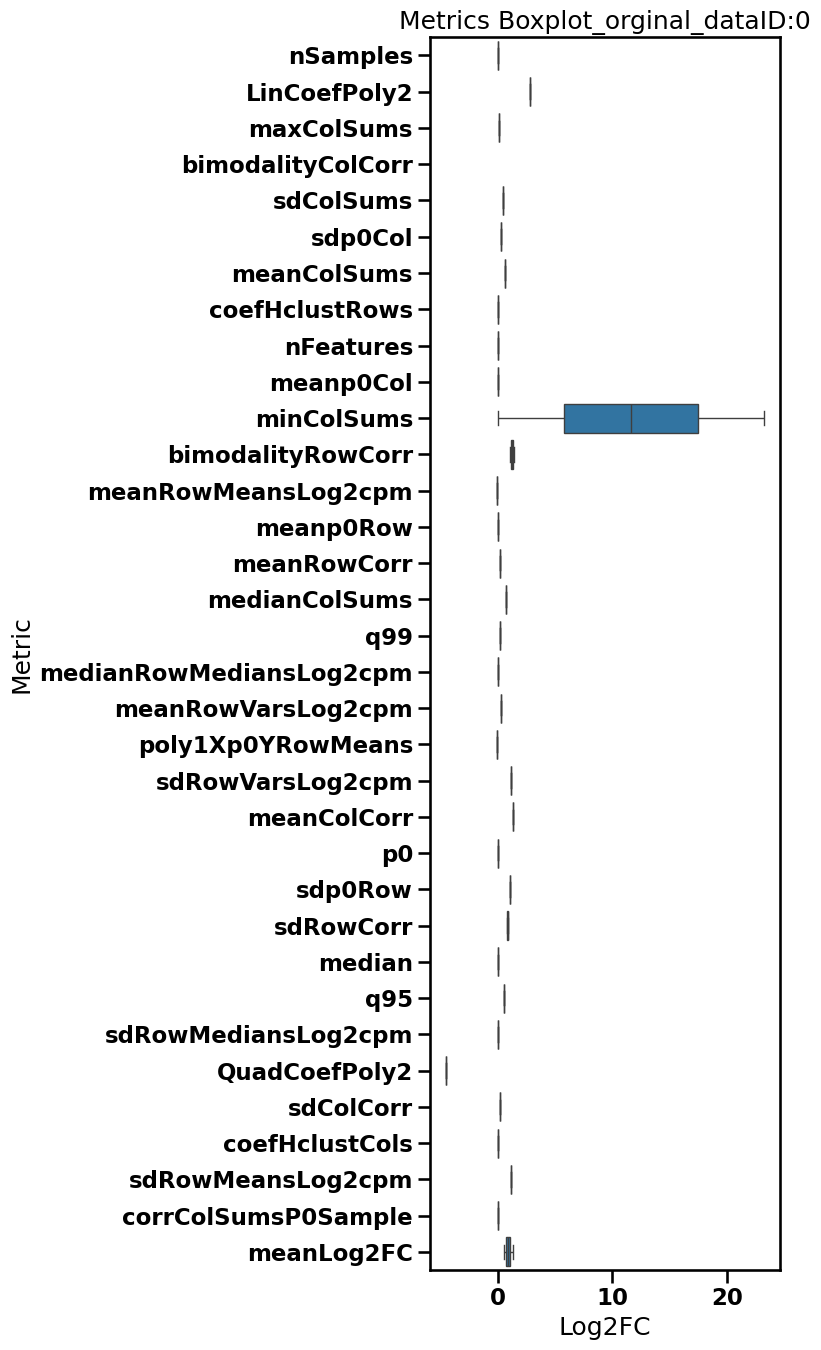

In [94]:
dp.plot_metrics()

mmcontext.eval.data_properties - WARNING - Property PCA Plot: Dropped columns with NaN values: {'bimodalityColCorr'}


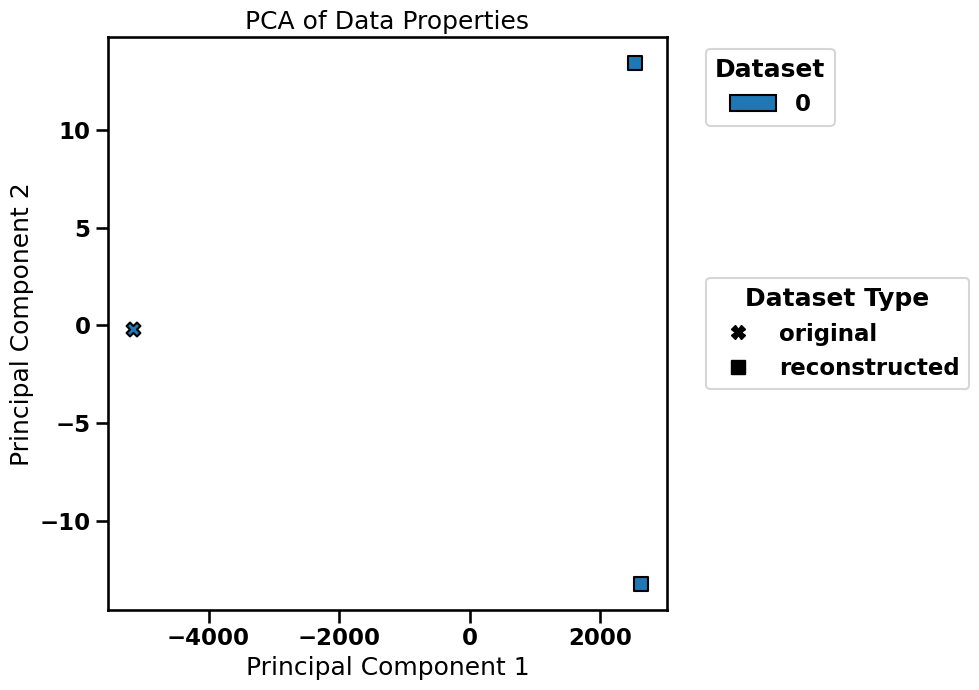

In [95]:
dp.plot_pca()